# Si.T.T. Basic Example

In this notebook, we will explore the basic features of Si.T.T. and show how to make the platform work on a basic level.

## Installing Si.T.T.

First, we need to integrate the Python library. Note, you need to install the required Python packages, first. A common way to do this is to use pip (search the Web for venv, Conda etc. for specific environments).

This is pretty straightforward (upgrade will ensure you have the latest version of Si.T.T. installed):

In [ ]:
!pip install --upgrade sitt

If you want to uninstall Si.T.T., you can do so by running the following command:

```console
pip uninstall -y sitt
```

## Basic Usage

After you have installed Si.T.T., you can import the library (we will also import a couple if other modules):

In [1]:
import sitt

## Configuration

In order to run a simulation, you need a configuration. The configuration defines all the variables, modules and simulation steps needed. For the sake of demonstration, we will create the configuration using Python.

In [2]:
config = sitt.Configuration()
print(config)

!!python/object:sitt.base.Configuration
break_simulation_after: 100
output: []
preparation: []
quiet: false
simulation: []
simulation_end: null
simulation_parallelism: !!python/object/apply:sitt.base.Parallelism
- none
simulation_start: null
verbose: false



As you can see, the configuration is a simple Python object. There are three main components of the simulation:

* Preparation: prepare data
* Simulation: actual simulation
* Output: showing or saving data

You can read more on these components in the [Concept Readme](../readmes/concept.md).


## Preparation

For now, let us look at the first part, the preparation. We will skip the simulation and output steps, and import a serialized graph (containing an arbitrary set of hubs and roads in Southern Austria):

In [3]:
# Skip simulation (and output)
config.skip_step = sitt.SkipStep.SIMULATION

# we will also make the output verbose, so we can see what the application is doing in its log output.
config.verbose = True

# Create an import module for the preparation component and add it the preparation component
graph_load = sitt.preparation.GraphLoad(filename='example_graph.pkl')
config.preparation.append(graph_load)

To see what is in the graph, we can use another module:

In [4]:
preparation_debug = sitt.preparation.DebugDisplayRoadsAndHubs()
config.preparation.append(preparation_debug)

Now let us run the application (the preparation, that is) and see what the debug output will show us. The simulation can be run by creating a core object and running it:

2022-10-14 11:49:05,724 ******** Preparation: started ********
2022-10-14 11:49:05,729 Loading graph from: example_graph.pkl
2022-10-14 11:49:05,733 Displaying roads and hubs
2022-10-14 11:49:05,734 Drawing network.


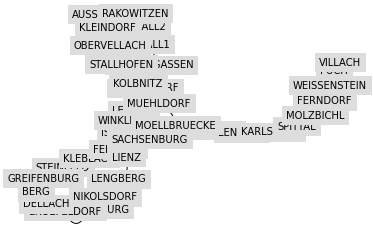

2022-10-14 11:49:07,712 ******** Preparation: finished ********


In [5]:
core = sitt.Core(config)
core.run()

You can see the network... kind of, the image is a bit too small, but you get a first impression. Now let us check the data a bit more thoroughly. What paths could we take from point A to point B and how would the roads look like?

No problem, let us update the debug and just output all possible paths between Lienz and Villach:

2022-10-14 11:49:15,096 ******** Preparation: started ********
2022-10-14 11:49:15,099 Loading graph from: example_graph.pkl
2022-10-14 11:49:15,106 Displaying roads and hubs
2022-10-14 11:49:15,267 Drawing 6 route(s) from LIENZ to VILLACH.


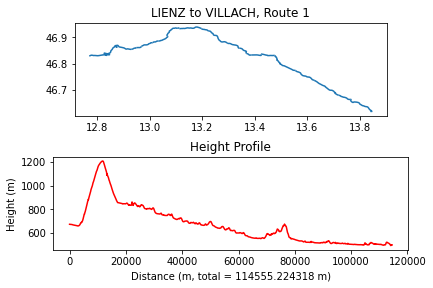

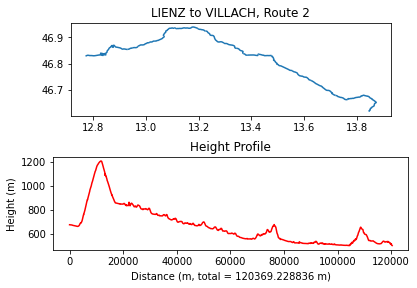

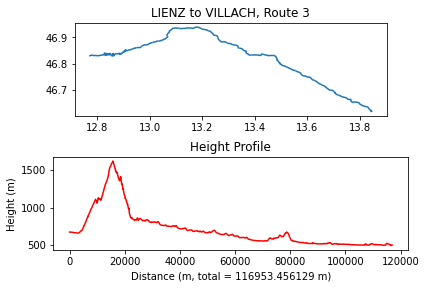

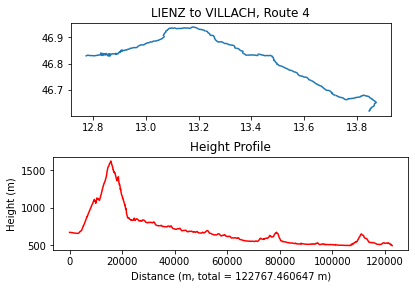

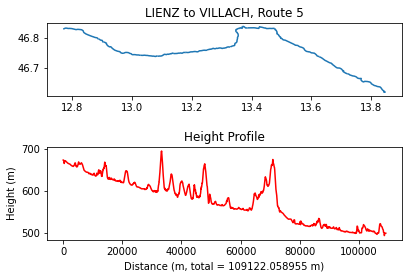

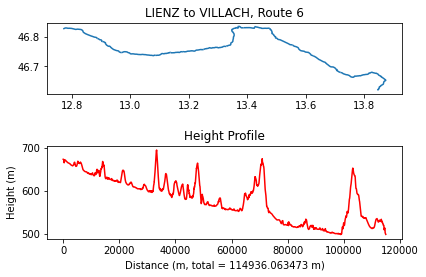

2022-10-14 11:49:16,362 ******** Preparation: finished ********


In [6]:
# turn off showing whole network
preparation_debug.draw_network = False

# set start and end points
preparation_debug.start = 'LIENZ'
preparation_debug.end = 'VILLACH'

core.run()

Wow, there six possible routes including height profiles. Time to start the simulation!

## A Simple Simulation

We will use a very simple simulation runner: An agent travelling 5 kph up to a maximum of 6 hours a day (so 30 km maximum which is about average for a normal person on foot). The agent will slow a bit on slopes, we will use a linear factor to simulate this. Granted, this is not a very good simulation (some exponential function would be more precise), but for the sake of simplicity, it will do.

In [7]:
# create new config
config = sitt.Configuration()

# Skip output
config.skip_step = sitt.SkipStep.OUTPUT

# we will also make the output verbose, so we can see what the application is doing in its log output.
config.verbose = True

# Create an import module for the preparation component and add it the preparation component
graph_load = sitt.preparation.GraphLoad(filename='example_graph.pkl')
config.preparation.append(graph_load)

# This is the new part: Create a simple simulation runner
simple_runner = sitt.simulation.SimpleRunner(speed=5.0, time_per_day=6.0)
config.simulation.append(simple_runner)

# Set start and end points of the simulation
config.simulation_start = 'LIENZ'
config.simulation_end = 'VILLACH'

# Run the core
core = sitt.Core(config)
core.run()

2022-10-14 11:49:20,510 ******** Preparation: started ********
2022-10-14 11:49:20,511 Loading graph from: example_graph.pkl
2022-10-14 11:49:20,514 ******** Preparation: finished ********
2022-10-14 11:49:20,515 ******** Simulation: started ********
2022-10-14 11:49:20,516 start:       LIENZ
2022-10-14 11:49:20,517 end:         VILLACH
2022-10-14 11:49:20,517 parallelism: none
2022-10-14 11:49:20,518 7e55bd705c5abbcf32645e41319bc0c7 is starting (LIENZ-ISELSBERG-1 → ISELSBERG-WINKLERN-1 → WINKLERN-LAINACH-1 → LAINACH-WITSCHDORF-1 → WITSCHDORF-PLAPPERGASSEN-1 → PLAPPERGASSEN-STALL1-1 → STALL1-STALL2-1 → STALL2-RAKOWITZEN-1 → RAKOWITZEN-AUSSERFRAGANT-1 → AUSSERFRAGANT-KLEINDORF → KLEINDORF-OBERVELLACH-1 → OBERVELLACH-STALLHOFEN-1 → STALLHOFEN-KOLBNITZ-1 → KOLBNITZ-MUEHLDORF-1 → MUEHLDORF-MOELLBRUECKE-1 → MOELLBRUECKE-B100MERGE-1 → B100MERGE-LENDORF-1 → LENDORF-KARLSDORF-1 → KARLSDORF-SPITTAL-1 → SPITTAL-MOLZBICHL-1 → MOLZBICHL-FERNDORF-1 → FERNDORF-WEISSENSTEIN-1 → WEISSENSTEIN-PUCH-1 → 

State 7e55bd705c5abbcf32645e41319bc0c7 (LIENZ-ISELSBERG-1 → ISELSBERG-WINKLERN-1 → WINKLERN-LAINACH-1 → LAINACH-WITSCHDORF-1 → WITSCHDORF-PLAPPERGASSEN-1 → PLAPPERGASSEN-STALL1-1 → STALL1-STALL2-1 → STALL2-RAKOWITZEN-1 → RAKOWITZEN-AUSSERFRAGANT-1 → AUSSERFRAGANT-KLEINDORF → KLEINDORF-OBERVELLACH-1 → OBERVELLACH-STALLHOFEN-1 → STALLHOFEN-KOLBNITZ-1 → KOLBNITZ-MUEHLDORF-1 → MUEHLDORF-MOELLBRUECKE-1 → MOELLBRUECKE-B100MERGE-1 → B100MERGE-LENDORF-1 → LENDORF-KARLSDORF-1 → KARLSDORF-SPITTAL-1 → SPITTAL-MOLZBICHL-1 → MOLZBICHL-FERNDORF-1 → FERNDORF-WEISSENSTEIN-1 → WEISSENSTEIN-PUCH-1 → PUCH-VILLACH-1), FINISHED
State 90a8a6f31e38d69efc428c80b7d9b156 (LIENZ-ISELSBERG-1 → ISELSBERG-WINKLERN-1 → WINKLERN-LAINACH-1 → LAINACH-WITSCHDORF-1 → WITSCHDORF-PLAPPERGASSEN-1 → PLAPPERGASSEN-STALL1-1 → STALL1-STALL2-1 → STALL2-RAKOWITZEN-1 → RAKOWITZEN-AUSSERFRAGANT-1 → AUSSERFRAGANT-KLEINDORF → KLEINDORF-OBERVELLACH-1 → OBERVELLACH-STALLHOFEN-1 → STALLHOFEN-KOLBNITZ-1 → KOLBNITZ-MUEHLDORF-1 → MUEHLDORF

As you can experiment a bit, changing values or reversing the order of the simulation start and end. If you change the values too much, you might end up with paths that are cancelled due to the agent not being able to traverse this particular path.

In [ ]:
# TODO: more to come